In [15]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import re
import time
from numpy.random import seed
from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model



In [2]:
train = pd.read_csv('/kaggle/input/enzyme-classification/train(1).csv')
train.head()

,Unnamed: 0,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
0,0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11
1,1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13
2,2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16
3,3,0003XVE3,MKNTSLSTTLTMNDTIAAIATPLGKGAISIIKISGHNALNILKQLT...,creature3,class12
4,4,00049BS0,MGNRLTKIYTKTGDSGLTGLADGSRTEKDSLRIFVIGDVDELNSLL...,creature8,class13


In [4]:
test = pd.read_csv('/kaggle/input/enzyme-classification/test.csv')
test.head()

,Unnamed: 0,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
0,6,000DTCAX,MQNSALKAWLDSSYLSGSNQSWIEQLYEDFLTDPDSVDANWRLTFQ...,creature0,class0
1,9,000EJ2PW,MRVIRPVEHADIAALMQLAGKTGGGLTSLPANEATLAARIERALKT...,creature2,class9
2,10,000KLDTU,MTTLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVI...,creature2,class8
3,12,0010HHS7,MLTKDLSVTFCGVKFPNPFCLSSSPVGNCYEMCAKAYDTGWGGIVF...,creature2,class18
4,15,0017X80Q,MLEQVCQLARNAGDAIMQVYDGAKPVEYARKQDDSPVTAADIAAHT...,creature2,class2


In [5]:
# Replacing amino acids (U, B, Z) with X
X_train = [re.sub(r"[UZB]", "X", sequence) for sequence in train.SEQUENCE]
X_test = [re.sub(r"[UZB]", "X", sequence) for sequence in test.SEQUENCE]

In [6]:
# tokenize the sequences on the char level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

In [8]:
# splitting the data
X_train, X_val,  y_train, y_val = train_test_split(X_train,train.LABEL ,
                                   random_state=49,
                                   test_size=0.2,
                                    stratify=train.LABEL,
                                   shuffle=True)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [9]:
# setting ou parameters
seed(1)
tf.random.set_seed(seed=2)
EPOCHS = 2
batch_size = 512
max_len = 384
lr = 0.001

In [10]:
 #tokenize train and val

xtrain = tokenizer.texts_to_sequences(X_train)
xval = tokenizer.texts_to_sequences(X_val)

# pad sequence
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,padding='post',truncating='post',maxlen=max_len)
xval = tf.keras.preprocessing.sequence.pad_sequences(xval,padding='post',truncating='post',maxlen=max_len)

word_index = tokenizer.word_index
len(word_index)

21

In [16]:
# convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
# one hot encoding
ytrain_enc = to_categorical(y_train_encoded)
yval_enc = to_categorical(y_val_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [17]:
def build_model(max_len, word_index):
    sequence_input = Input(shape=(max_len,))

    embedding_layer1 = Embedding(input_dim=len(word_index) + 1,
                                 output_dim=128,
                                 input_length=max_len)

    x_emb1 = embedding_layer1(sequence_input)
    x = SpatialDropout1D(0.2)(x_emb1)
    conv1= Conv1D(1024,kernel_size=7, padding="same", activation='relu', kernel_initializer="he_uniform")(x)
    conv2= Conv1D(2048,kernel_size=7, padding="same", activation='relu', kernel_initializer="he_uniform")(conv1)
    avg_pool1 = GlobalAveragePooling1D()(conv2)
    max_pool1 = GlobalMaxPooling1D()(conv2)

    x = concatenate([avg_pool1, max_pool1])
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)
    preds = Dense(20, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.summary()
    return model

In [18]:
model = build_model(max_len, word_index)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 384, 128)             2816      ['input_1[0][0]']             
                                                                                                  
 spatial_dropout1d (Spatial  (None, 384, 128)             0         ['embedding[0][0]']           
 Dropout1D)                                                                                       
                                                                                                  
 conv1d (Conv1D)             (None, 384, 1024)            918528    ['spatial_dropout1d[0][0]'

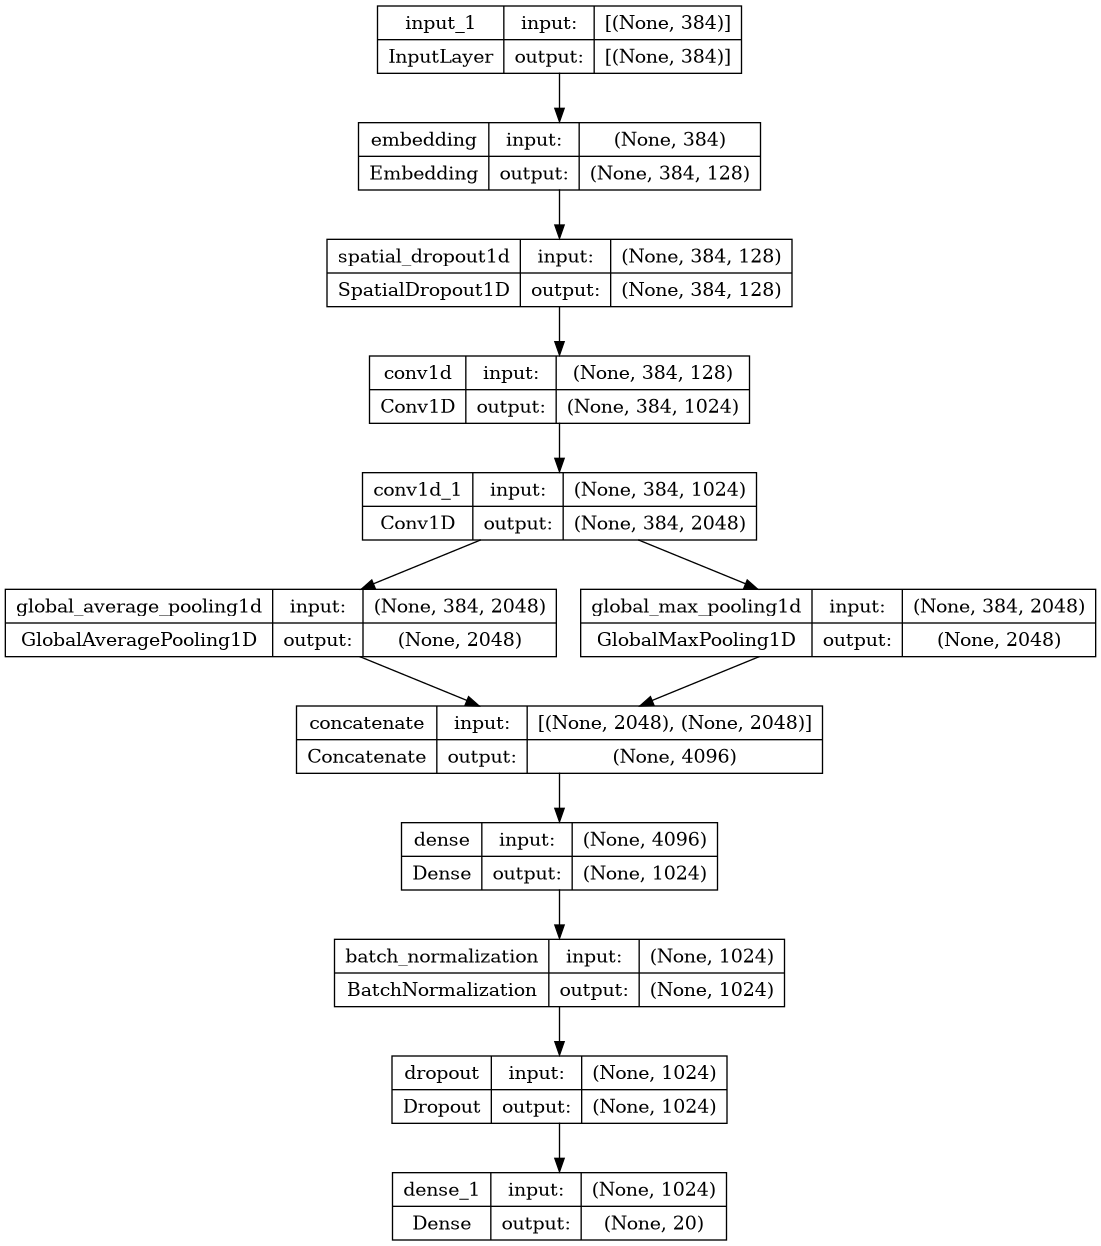

In [19]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [20]:
model.compile(loss='categorical_crossentropy',
                      optimizer= tf.keras.optimizers.Adam(learning_rate=lr)
                      ,metrics=['accuracy'])

# Fit the model with early stopping and reduce on plateau callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')


In [21]:
start_time = time.time()
history = model.fit(xtrain, y=ytrain_enc, batch_size=512, epochs=20,
          verbose=1, validation_data=(xval, yval_enc), callbacks=[earlystop,rl])

end_time = time.time()
time = end_time - start_time

print(f"The training took {time} seconds.")

Epoch 1/20
1062/1062 [==============================] - 1842s 2s/step - loss: 0.3898 - accuracy: 0.9003 - val_loss: 0.2483 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 2/20
1062/1062 [==============================] - 1795s 2s/step - loss: 0.1253 - accuracy: 0.9690 - val_loss: 0.0654 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 3/20
1062/1062 [==============================] - 1794s 2s/step - loss: 0.0999 - accuracy: 0.9743 - val_loss: 0.1208 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 4/20
1062/1062 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9765
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1062/1062 [==============================] - 1793s 2s/step - loss: 0.0844 - accuracy: 0.9765 - val_loss: 0.0905 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 5/20
1062/1062 [==============================] - 1794s 2s/step - loss: 0.0583 - accuracy: 0.9824 - val_loss: 0.0289 - val_accuracy: 0.9932 - lr: 1.0000e-04
Epoch 6/20
1062/1062 [===============

In [22]:
xtest = tokenizer.texts_to_sequences(X_test)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,padding='post',truncating='post',maxlen=max_len)

In [23]:
y_test_encoded = label_encoder.transform(test.LABEL)

# Convert the integer-encoded labels to one-hot encoded format
y_test_enc = to_categorical(y_test_encoded)

# Evaluate the model on the test set
eval_results = model.evaluate(xtest, y_test_enc)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


4300/4300 [==============================] - 104s 24ms/step - loss: 0.9503 - accuracy: 0.8203


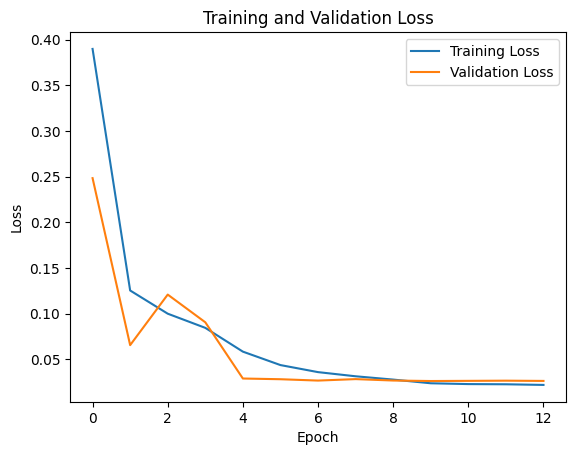

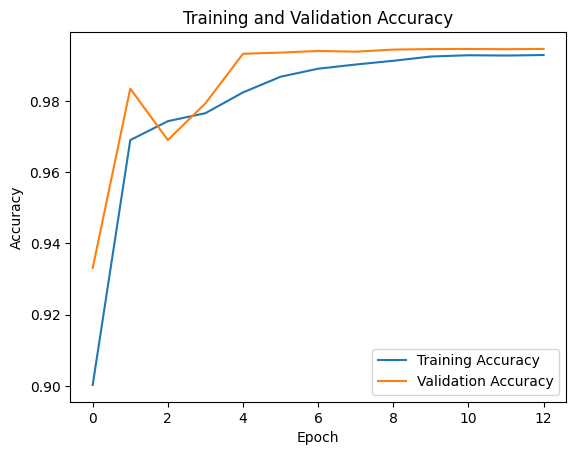

In [24]:
def plot_training_history(history):
    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)

In [25]:
# predict the class probabilities
y_pred_prob = model.predict(xtest)

4300/4300 [==============================] - 95s 22ms/step


In [26]:
from sklearn.metrics import classification_report

def print_classification_report():
    y_true = label_encoder.inverse_transform(y_test_enc.argmax(axis=1))
    y_pred = label_encoder.inverse_transform(y_pred_prob.argmax(axis=1))
    # Classification report for all enzymes
    report = classification_report(
            y_true,
            y_pred,
            target_names=label_encoder.classes_,
            output_dict=True,
        )
    # Round Data for better readability
    report = pd.DataFrame(report).T
    report = report.round(2)


    # Sort on F1-score
    report = pd.concat((
        report.head(20).sort_values('f1-score', ascending=False),
        report.tail(3),
      ))

    display(report)

In [27]:
print_classification_report()

,precision,recall,f1-score,support
class5,0.94,0.98,0.96,3450.00
class8,0.95,0.93,0.94,5089.00
class17,0.90,0.96,0.93,2814.00
class0,0.89,0.93,0.91,1970.00
class11,0.84,0.94,0.89,11844.00
class13,0.83,0.93,0.88,3388.00
class14,0.97,0.79,0.88,3258.00
class7,0.76,1.00,0.87,1220.00
class1,0.90,0.82,0.86,9322.00
class15,0.91,0.79,0.85,6014.00
